In [81]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../')
import utils
from scripts.asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [82]:
%matplotlib notebook

In [83]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean',
               'temporal_histogram_distance-mean'
               ]

FEATURES_SL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean',
               'temporal_histogram_distance-mean'
               ]
FEATURES_META = ['cat_cl_pred','ocsvm_pred']
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [103]:
# read data
data = utils.load_data('../../../data/data-new-metrics.csv')
# remove low bitrate renditions
data = data[~data.rendition.str.contains('bitrate')]
data = data[~data.rendition.str.contains('chroma')]
data
data = VideoAssetProcessor.rescale_to_resolution(data, FULL_FEATURES)
len_before = len(data)

Upscaling temporal_dct temporal_dct-mean
Upscaling temporal_gaussian_mse temporal_gaussian_mse-mean
Upscaling temporal_gaussian_difference temporal_gaussian_difference-mean
Upscaling temporal_histogram_distance temporal_histogram_distance-mean


In [104]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 0 NA rows


In [105]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_idx = ~data.index.isin(train_data.index)
test_data = data[test_idx]
y_test = test_data['target']
y_train = train_data['target']
# save split
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [119]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(50)

Test data top rendition types:


rendition
144p_flip_vertical            13
240p_flip_vertical            13
480p_flip_vertical            15
480p_watermark-345x114       303
360p_vignette                309
720p_watermark-856x856       311
1080p_watermark-345x114      312
144p_watermark-856x856       313
144p_vignette                315
480p_vignette                316
720p_flip_horizontal         319
720p                         320
480p                         321
1080p_flip_horizontal        321
720p_watermark-345x114       324
144p_watermark-345x114       324
360p_black_and_white         324
360p_watermark-345x114       326
144p_black_and_white         326
360p                         327
240p_watermark-856x856       327
144p                         328
720p_watermark               328
480p_watermark-856x856       330
720p_vignette                331
144p_flip_horizontal         333
240p_watermark-345x114       333
1080p_watermark              333
360p_rotate_90_clockwise     334
1080p_watermark-856x856      334


In [107]:
train_data[FULL_FEATURES].describe()

,size_dimension_ratio,temporal_dct-mean,temporal_gaussian_difference-mean,temporal_gaussian_mse-mean,temporal_histogram_distance-mean,temporal_threshold_gaussian_difference-mean
count,89732.000000,8.973200e+04,8.973200e+04,89732.000000,8.973200e+04,89732.000000
mean,2.956195,1.181635e+07,6.223572e+09,16378.349428,1.584695e+05,22044.666186
std,1.375813,2.522483e+07,1.351779e+10,46387.851394,5.422460e+05,25646.720440
min,0.016935,2.671321e+02,4.398244e+04,0.000220,0.000000e+00,0.000000
25%,2.128101,2.578504e+05,1.609556e+08,73.670767,2.371420e+03,1008.444444
50%,2.962325,1.770533e+06,8.082302e+08,928.940517,6.363462e+03,4724.000000
75%,3.567212,9.789811e+06,4.897870e+09,8887.653098,3.256361e+04,44070.611111
max,19.957878,4.743106e+08,1.707865e+11,896108.825231,8.507153e+06,129600.000000


In [108]:
(train_data['size']/(train_data['dimension_x']*train_data['dimension_y'])).describe()

count    89732.000000
mean         2.956195
std          1.375813
min          0.016935
25%          2.128101
50%          2.962325
75%          3.567212
max         19.957878
dtype: float64

In [109]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     1648
1    14152
Name: target, dtype: int64

In [110]:
# test renditions by type
print('Test data FPS renditions count:')
test_data.

Test data FPS renditions count:


id
1080p_watermark-856x856_24-30fps_gpu/-apHZNnZSL4.mp4            1
1080p_rotate_90_clockwise_24-60fps/-ewkJboodaE.mp4              1
1080p_vignette_25-30fps/4PpxM7P2M1c.mp4                         1
144p_24-60fps/4f49m5mZE3M.mp4                                   0
1080p_flip_horizontal_30-24fps_gpu/3fSUvsWTqpA.mp4              1
1080p_25-30fps_gpu/DjL38nRWbkE.mp4                              0
1080p_flip_vertical_24-60fps_gpu/nmI2HLSirHY.mp4                1
144p_24-30fps/0b9uySaNopg.mp4                                   0
144p_vignette_30-24fps_gpu/GOh-RhD_p2Y.mp4                      1
144p_25-30fps_gpu/2X-b-7gWMQI.mp4                               0
144p_rotate_90_counterclockwise_30-24fps_gpu/VUtmahnh1nM.mp4    1
1080p_vignette_24-60fps_gpu/-QmLoLkURHw.mp4                     1
1080p_rotate_90_clockwise_24-30fps/-QmLoLkURHw.mp4              1
1080p_watermark-856x856_24-30fps/1jKx0x-ymYM.mp4                1
144p_flip_horizontal_24-60fps/iSleTtlfTCw.mp4                   1
144p_vi

In [111]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [112]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5434822	total: 30.7ms	remaining: 15.3s
1:	learn: 0.4328675	total: 42.4ms	remaining: 10.6s
2:	learn: 0.3434902	total: 49.7ms	remaining: 8.24s
3:	learn: 0.2832329	total: 56.8ms	remaining: 7.05s
4:	learn: 0.2305417	total: 64.2ms	remaining: 6.35s
5:	learn: 0.1926233	total: 71.3ms	remaining: 5.87s
6:	learn: 0.1647292	total: 78.9ms	remaining: 5.56s
7:	learn: 0.1452633	total: 86.4ms	remaining: 5.31s
8:	learn: 0.1303389	total: 93.5ms	remaining: 5.1s
9:	learn: 0.1169787	total: 101ms	remaining: 4.93s
10:	learn: 0.1080668	total: 108ms	remaining: 4.79s
11:	learn: 0.1005810	total: 115ms	remaining: 4.67s
12:	learn: 0.0942184	total: 122ms	remaining: 4.57s
13:	learn: 0.0886550	total: 129ms	remaining: 4.47s
14:	learn: 0.0850078	total: 137ms	remaining: 4.42s
15:	learn: 0.0808667	total: 145ms	remaining: 4.38s
16:	learn: 0.0772914	total: 152ms	remaining: 4.32s
17:	learn: 0.0746057	total: 159ms	remaining: 4.25s
18:	learn: 0.0726000	total: 166ms	remaining: 4.21s
19:	learn: 0.0704564	total: 173ms

177:	learn: 0.0419209	total: 1.45s	remaining: 2.62s
178:	learn: 0.0418827	total: 1.46s	remaining: 2.62s
179:	learn: 0.0418557	total: 1.47s	remaining: 2.61s
180:	learn: 0.0418255	total: 1.48s	remaining: 2.61s
181:	learn: 0.0417960	total: 1.49s	remaining: 2.6s
182:	learn: 0.0417592	total: 1.49s	remaining: 2.59s
183:	learn: 0.0417339	total: 1.5s	remaining: 2.58s
184:	learn: 0.0416749	total: 1.51s	remaining: 2.57s
185:	learn: 0.0416489	total: 1.52s	remaining: 2.56s
186:	learn: 0.0415936	total: 1.52s	remaining: 2.55s
187:	learn: 0.0415592	total: 1.53s	remaining: 2.54s
188:	learn: 0.0415267	total: 1.54s	remaining: 2.53s
189:	learn: 0.0414702	total: 1.55s	remaining: 2.52s
190:	learn: 0.0413981	total: 1.55s	remaining: 2.51s
191:	learn: 0.0413803	total: 1.56s	remaining: 2.5s
192:	learn: 0.0413245	total: 1.57s	remaining: 2.5s
193:	learn: 0.0412877	total: 1.58s	remaining: 2.49s
194:	learn: 0.0412353	total: 1.58s	remaining: 2.48s
195:	learn: 0.0412030	total: 1.59s	remaining: 2.47s
196:	learn: 0.04

350:	learn: 0.0366508	total: 2.83s	remaining: 1.2s
351:	learn: 0.0366356	total: 2.84s	remaining: 1.2s
352:	learn: 0.0366203	total: 2.85s	remaining: 1.19s
353:	learn: 0.0366072	total: 2.86s	remaining: 1.18s
354:	learn: 0.0365723	total: 2.87s	remaining: 1.17s
355:	learn: 0.0365574	total: 2.87s	remaining: 1.16s
356:	learn: 0.0365383	total: 2.88s	remaining: 1.15s
357:	learn: 0.0365181	total: 2.89s	remaining: 1.15s
358:	learn: 0.0364797	total: 2.9s	remaining: 1.14s
359:	learn: 0.0364630	total: 2.9s	remaining: 1.13s
360:	learn: 0.0364261	total: 2.91s	remaining: 1.12s
361:	learn: 0.0364089	total: 2.92s	remaining: 1.11s
362:	learn: 0.0363824	total: 2.93s	remaining: 1.1s
363:	learn: 0.0363675	total: 2.93s	remaining: 1.1s
364:	learn: 0.0363363	total: 2.94s	remaining: 1.09s
365:	learn: 0.0363007	total: 2.95s	remaining: 1.08s
366:	learn: 0.0362828	total: 2.96s	remaining: 1.07s
367:	learn: 0.0362637	total: 2.96s	remaining: 1.06s
368:	learn: 0.0362415	total: 2.98s	remaining: 1.06s
369:	learn: 0.0362

In [113]:
# voting model
test_data['meta_voting_pred_label'] = np.where(test_data['ocsvm_pred_label']==0, 0, test_data['cat_cl_y_pred_label'])
test_data[['meta_voting_pred_label','cat_cl_y_pred_label','ocsvm_pred_label']]
#test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2 + test_data['ocsvm_pred'])/2

,meta_voting_pred_label,cat_cl_y_pred_label,ocsvm_pred_label
id,,,
720p_black_and_white/ALTlJUod2jU.mp4,1,1,1.0
144p_rotate_90_clockwise/g0HJWlDb-ao.mp4,1,1,1.0
720p_rotate_90_clockwise/E1Q-z2emjWQ.mp4,1,1,1.0
720p_flip_horizontal/rgchsYcBVWI.mp4,1,1,1.0
1080p_vignette/ikq4BH64p_I.mp4,1,1,1.0
720p_rotate_90_clockwise/9jmHc2dMA7o.mp4,1,1,1.0
1080p_black_and_white/WzWJpCfhhgU.mp4,1,1,1.0
720p/d0lOMYVQsPs.mp4,0,0,0.0
144p_black_and_white/beVH1-KiSbM.mp4,1,1,1.0


In [114]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


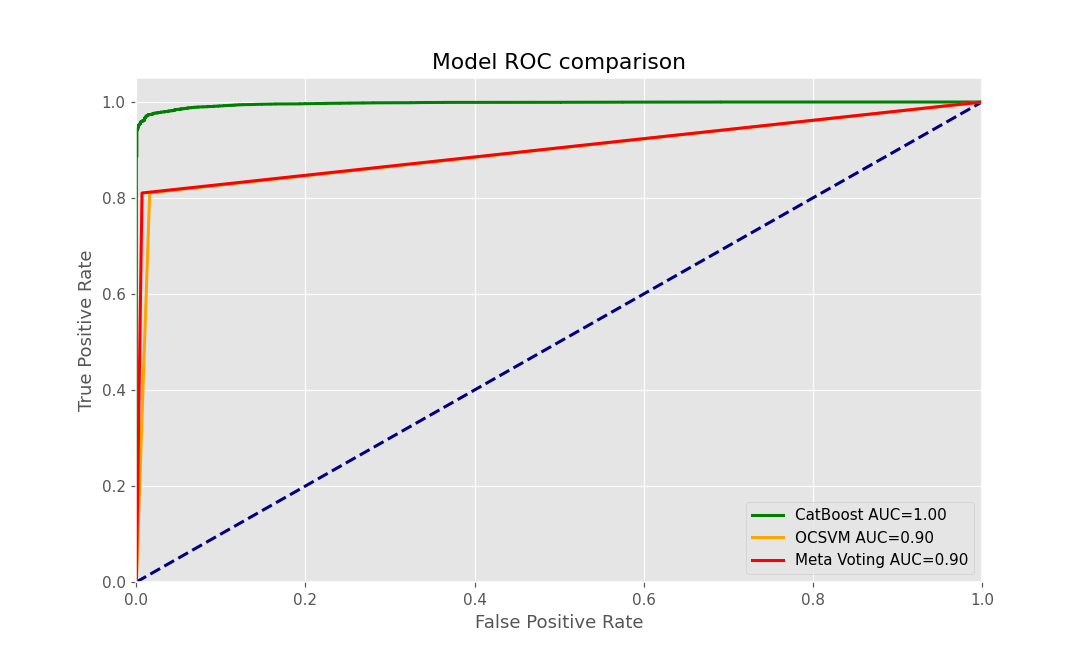

##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1648
           1       0.99      0.99      0.99     14152

    accuracy                           0.98     15800
   macro avg       0.95      0.96      0.95     15800
weighted avg       0.98      0.98      0.98     15800

CatBoost confusion matrix:
[[ 1542   106]
 [  169 13983]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
              precision    recall  f1-score   support

           0       0.38      0.98      0.55      1648
           1       1.00      0.81      0.89     14152

    accuracy                           0.83     15800
   macro avg       0.69      0.90      0.72     15800
weighted avg       0.93      0.83      0.86     15800

OCSVM confusion matrix:
[[ 1622    26]
 [ 2677 11475]]
##################
Meta Voting ROC threshold: 0.5
Meta Voting classification repo

In [115]:
multi_model_perf(y_test, [test_data['cat_cl_pred'], test_data['ocsvm_pred_label'], test_data['meta_voting_pred_label']], 
              ['CatBoost', 'OCSVM','Meta Voting'], report_threshold=[0.5,0.5,0.5])

In [116]:
print('Hardest rendition types:')
test_data[test_data.cat_cl_y_pred_label!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
480p_watermark-856x856     3
720p                       4
240p_watermark             5
144p_watermark             6
240p_black_and_white       8
144p_black_and_white       9
720p_watermark-345x114    10
480p                      10
480p_watermark-345x114    16
360p                      18
240p_watermark-345x114    27
240p                      30
360p_watermark-345x114    30
144p_watermark-345x114    35
144p                      43
Name: rendition, dtype: int64

In [117]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,3,27.691566,temporal_gaussian_mse-mean
1,1,16.725491,temporal_dct-mean
2,5,16.671509,temporal_threshold_gaussian_difference-mean
3,0,13.147325,size_dimension_ratio
4,2,12.912167,temporal_gaussian_difference-mean
5,4,12.851941,temporal_histogram_distance-mean


FPS Renditions


<IPython.core.display.Javascript object>


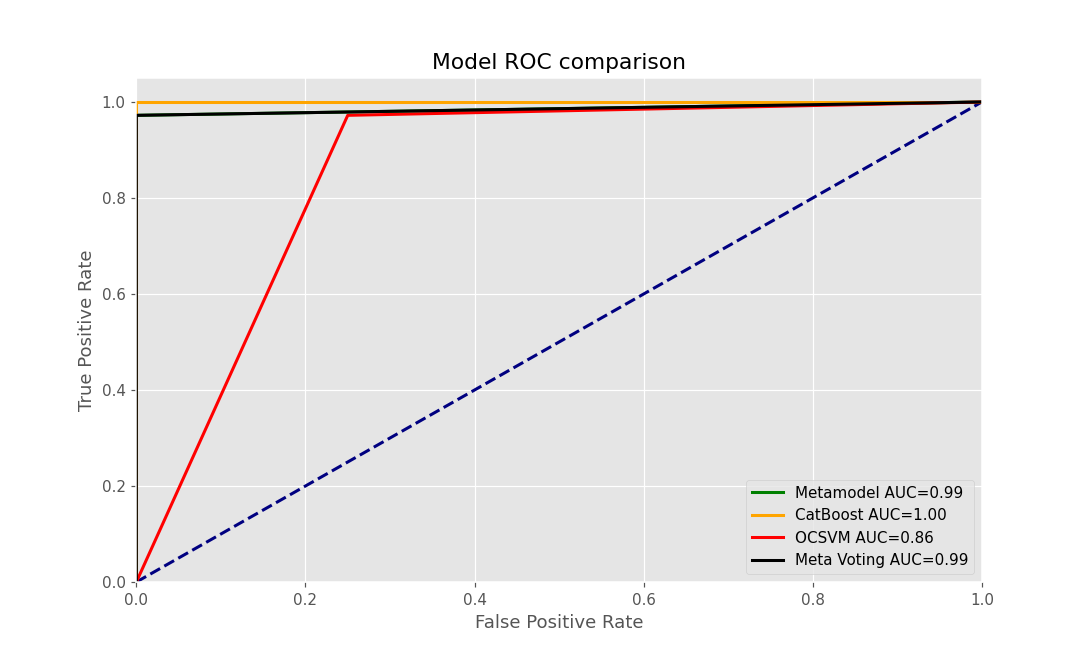

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.97      0.99        36

    accuracy                           0.98        44
   macro avg       0.94      0.99      0.96        44
weighted avg       0.98      0.98      0.98        44

Metamodel confusion matrix:
[[ 8  0]
 [ 1 35]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.95      1.00      0.97        36

    accuracy                           0.95        44
   macro avg       0.97      0.88      0.92        44
weighted avg       0.96      0.95      0.95        44

CatBoost confusion matrix:
[[ 6  2]
 [ 0 36]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
              precis

In [79]:
print('FPS Renditions')
fps_test_idx = test_data.id.str.contains('fps')
y_test_fps = test_data[fps_test_idx]['target']
multi_model_perf(y_test_fps, [test_data[fps_test_idx]['meta_voting_pred_label'], test_data[fps_test_idx]['cat_cl_pred'], test_data[fps_test_idx]['ocsvm_pred_label'],
                      test_data[fps_test_idx]['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.5])